In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

In [2]:
from sklearn.metrics import accuracy_score,precision_score,recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers,losses
from tensorflow.keras.models import Model

In [4]:
dataframe = pd.read_csv("https://storage.googleapis.com/download.tensorflow.org/data/ecg.csv",header=None)
raw_data = dataframe.values
dataframe.head()

,0,1,2,3,4,5,6,7,8,9,...,131,132,133,134,135,136,137,138,139,140
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818286,-1.250522,-0.477492,...,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1.0
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,...,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1.0
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490659,-1.183580,-0.394229,...,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,1.0
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,...,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,1.0
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,...,1.148884,0.958434,1.059025,1.371682,1.277392,0.960304,0.971020,1.614392,1.421456,1.0


In [5]:
labels = raw_data[:,-1]
data = raw_data[:,0:-1]
train_data, test_data, train_labels, test_labels = train_test_split(data,labels,test_size=0.2,random_state=21)

In [6]:
min_val = tf.reduce_min(train_data)
max_val = tf.reduce_max(train_data)

train_data = (train_data-min_val)/(max_val-min_val)
test_data = (test_data-min_val)/(max_val-min_val)

train_data = tf.cast(train_data,tf.float32)
test_data = tf.cast(test_data,tf.float32)

In [7]:
train_labels = train_labels.astype(bool)
test_labels = test_labels.astype(bool)

In [8]:
normal_train_data = train_data[train_labels]
normal_test_data = test_data[test_labels]

anomalous_train_data = train_data[~train_labels]
anomalous_test_data = test_data[~test_labels]

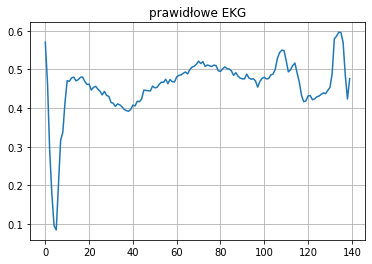

In [9]:
#prawidłowe EKG
plt.grid()
plt.plot(np.arange(140),normal_train_data[0])
plt.title('prawidłowe EKG')
plt.show()

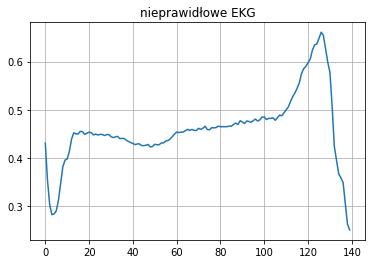

In [10]:
#nieprawidłowe EKG
plt.grid()
plt.plot(np.arange(140),anomalous_train_data[0])
plt.title('nieprawidłowe EKG')
plt.show()

In [11]:
#przygotowanie autoenkodera - detektora anomalii
class AnomalyDetector(Model):
    def __init__(self)->None:
        super(AnomalyDetector,self).__init__()
        self.encoder = tf.keras.Sequential([
            layers.Dense(32,activation='relu'),
            layers.Dense(16,activation='relu'),
            layers.Dense(8,activation='relu')
        ])
        self.decoder = tf.keras.Sequential([
            layers.Dense(16,activation='relu'),
            layers.Dense(32,activation='relu'),
            layers.Dense(140,activation='sigmoid')
        ])
    def call(self,x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [12]:
autoencoder = AnomalyDetector()
autoencoder.compile(optimizer='adam',loss='mae')

history = autoencoder.fit(normal_train_data,normal_train_data,
                          epochs=20,
                          batch_size=512,
                          validation_data=(test_data,test_data),
                          shuffle=True)

Epoch 1/20
5/5 [==============================] - 1s 56ms/step - loss: 0.0585 - val_loss: 0.0536
Epoch 2/20
5/5 [==============================] - 0s 10ms/step - loss: 0.0566 - val_loss: 0.0522
Epoch 3/20
5/5 [==============================] - 0s 11ms/step - loss: 0.0548 - val_loss: 0.0505
Epoch 4/20
5/5 [==============================] - 0s 10ms/step - loss: 0.0520 - val_loss: 0.0486
Epoch 5/20
5/5 [==============================] - 0s 12ms/step - loss: 0.0483 - val_loss: 0.0474
Epoch 6/20
5/5 [==============================] - 0s 10ms/step - loss: 0.0447 - val_loss: 0.0454
Epoch 7/20
5/5 [==============================] - 0s 10ms/step - loss: 0.0409 - val_loss: 0.0433
Epoch 8/20
5/5 [==============================] - 0s 10ms/step - loss: 0.0374 - val_loss: 0.0422
Epoch 9/20
5/5 [==============================] - 0s 11ms/step - loss: 0.0343 - val_loss: 0.0407
Epoch 10/20
5/5 [==============================] - 0s 12ms/step - loss: 0.0317 - val_loss: 0.0396
Epoch 11/20
5/5 [============

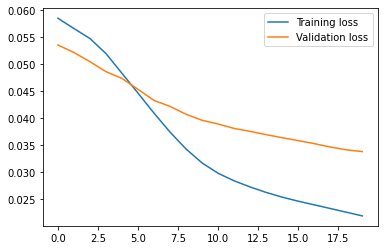

In [13]:
plt.plot(history.history["loss"],label='Training loss')
plt.plot(history.history["val_loss"],label='Validation loss')
plt.legend()

In [14]:
encoded_data = autoencoder.encoder(normal_test_data).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

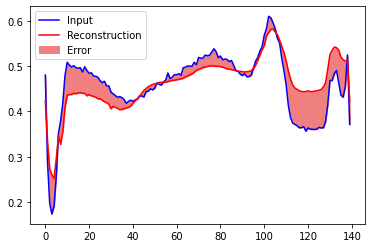

In [15]:
plt.plot(normal_test_data[0],'b')
plt.plot(decoded_data[0],'r')
plt.fill_between(np.arange(140),decoded_data[0],normal_test_data[0],color='lightcoral')
plt.legend(labels=["Input","Reconstruction","Error"])
plt.show()

In [16]:
encoded_data = autoencoder.encoder(anomalous_test_data).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

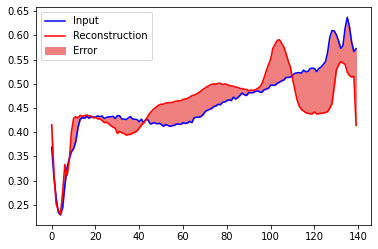

In [18]:
plt.plot(anomalous_test_data[0],'b')
plt.plot(decoded_data[0],'r')
plt.fill_between(np.arange(140),decoded_data[0],anomalous_test_data[0],color='lightcoral')
plt.legend(labels=["Input","Reconstruction","Error"])
plt.show()

74/74 [==============================] - 0s 1ms/step


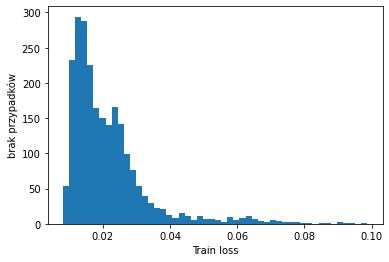

In [19]:
#wykrywanie anomalii

reconstruction = autoencoder.predict(normal_train_data)
train_loss = tf.keras.losses.mae(reconstruction,normal_train_data)

plt.hist(train_loss[None,:],bins=50)
plt.xlabel('Train loss')
plt.ylabel('brak przypadków')
plt.show()

In [20]:
#wartość progowa
threshold = np.mean(train_loss) + np.std(train_loss)
print(f"wartość progowa: {threshold}")

wartość progowa: 0.033441800624132156


52/52 [==============================] - 0s 1ms/step


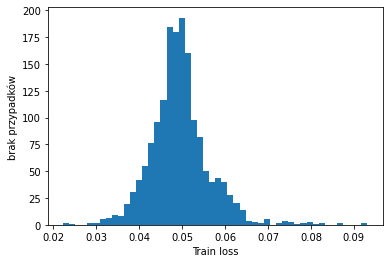

In [21]:
reconstruction = autoencoder.predict(anomalous_train_data)
train_loss = tf.keras.losses.mae(reconstruction,anomalous_train_data)

plt.hist(train_loss[None,:],bins=50)
plt.xlabel('Train loss')
plt.ylabel('brak przypadków')
plt.show()

In [26]:
def predict(model,data,threshold):
    reconstructions = model(data)
    loss = tf.keras.losses.mae(reconstructions,data)
    return tf.math.less(loss,threshold)

def print_stats(predictions,labels):
    print(f'Accuracy: {accuracy_score(labels,predictions)}')
    print(f"Precision: {precision_score(labels,predictions)}")
    print(f"Recall: {recall_score(labels,predictions)}")

In [27]:
pred = predict(autoencoder,test_data,threshold)
print_stats(pred,test_labels)

Accuracy: 0.942
Precision: 0.9921568627450981
Recall: 0.9035714285714286
